# Flowlines
This example details dynamic construction and plotting within a python script of synthetic flowlines generated from a plate model. For a general introduction to flowlines, see the GPlates user manual:

http://www.gplates.org/user-manual/Flowlines.html

The example goes through the case of creating flowline/motion path features within a script (assuming that we know enough to assign parameters like position of the seed points, plateid/conjugate plateid, and the time range and time sampling that we want for the feature). Then we can calculate motion paths for one (or several) rotation models, for different frames of reference.   

The flowline example uses the Tasman Sea, which in the GPlates default reconstruction model opened from ~90 Ma to ~52 (Ma), with rotation parameters from the study of Gaina et al (1998), which are used in the Seton et al global compilation. The parameters we need to set to make a reasonable synthetic flowlines are as follows:

   - The seed points - typically, points on a present day mid-ocean ridge or (in this case) an extinct ridge axis
   - Plate IDs for the two plates that were spreading apart - in this case Australia (801) and the Lord Howe Rise (833)
   - The time range for the spreading (or at least, the section of the spreading you want to visualise the flowline for)


In [3]:
import numpy as np
import pygplates

# Rotation file to be used to generate synthetic flowlines
rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'

# Parameters required to define a flowline (as in GPlates)
SeedPoints = zip([-40,-43],[157,157.5])
left_plate = 801
right_plate = 833
times = np.arange(0,90,1.)     # using numpy to get a list of times in 1 Myr increments


### Create a flowline feature
The next section of codes generates a flowline feature within the script (analogous to the process in GPlates GUI of digitizing a new point and applying parameters to make it a flowline feature) 


In [4]:
# CREATE FLOWLINE
# POINTS ON THE FLOWLINE
multi_point = pygplates.MultiPointOnSphere(SeedPoints)

# Create the flowline feature
flowline_feature = pygplates.Feature.create_flowline(
    multi_point,
    times,
    valid_time=(np.max(times), np.min(times)),
    left_plate=left_plate,
    right_plate=right_plate)


### Make the flowline for a chosen reconstruction model
The flowline feature does not have any set flowline path, it is agnositic of rotation models. To make a synthetic flowline,  

In [5]:
# Load a rotation model (required to generate a synthetic flowline)
rotation_model=pygplates.RotationModel(rotation_filename)

# reconstruct the flowline - we want it in present day coordinates
reconstruction_time=0

# create an empty feature in which the reconstructed flowline geometries will be placed
reconstructed_flowlines = []

# call pygplates to generate the flowline feature
pygplates.reconstruct(flowline_feature, rotation_model, reconstructed_flowlines, reconstruction_time,
                  anchor_plate_id=1, reconstruct_type=pygplates.ReconstructType.flowline)


### Visualise the results
A useful way of assessing synthetic flowlines against observations is to plot them overlain on maps showing seafloor fabric, ideally gravity anomaly maps of the oceans derived from satellite altimetry. The code below plots the flowlines over the (low resolution) etopo raster image distributed with Basemap.

The flowline features are split into 'right' and 'left' sides, so plotting them takes a few lines of code that iterate over each half of each flowline.  

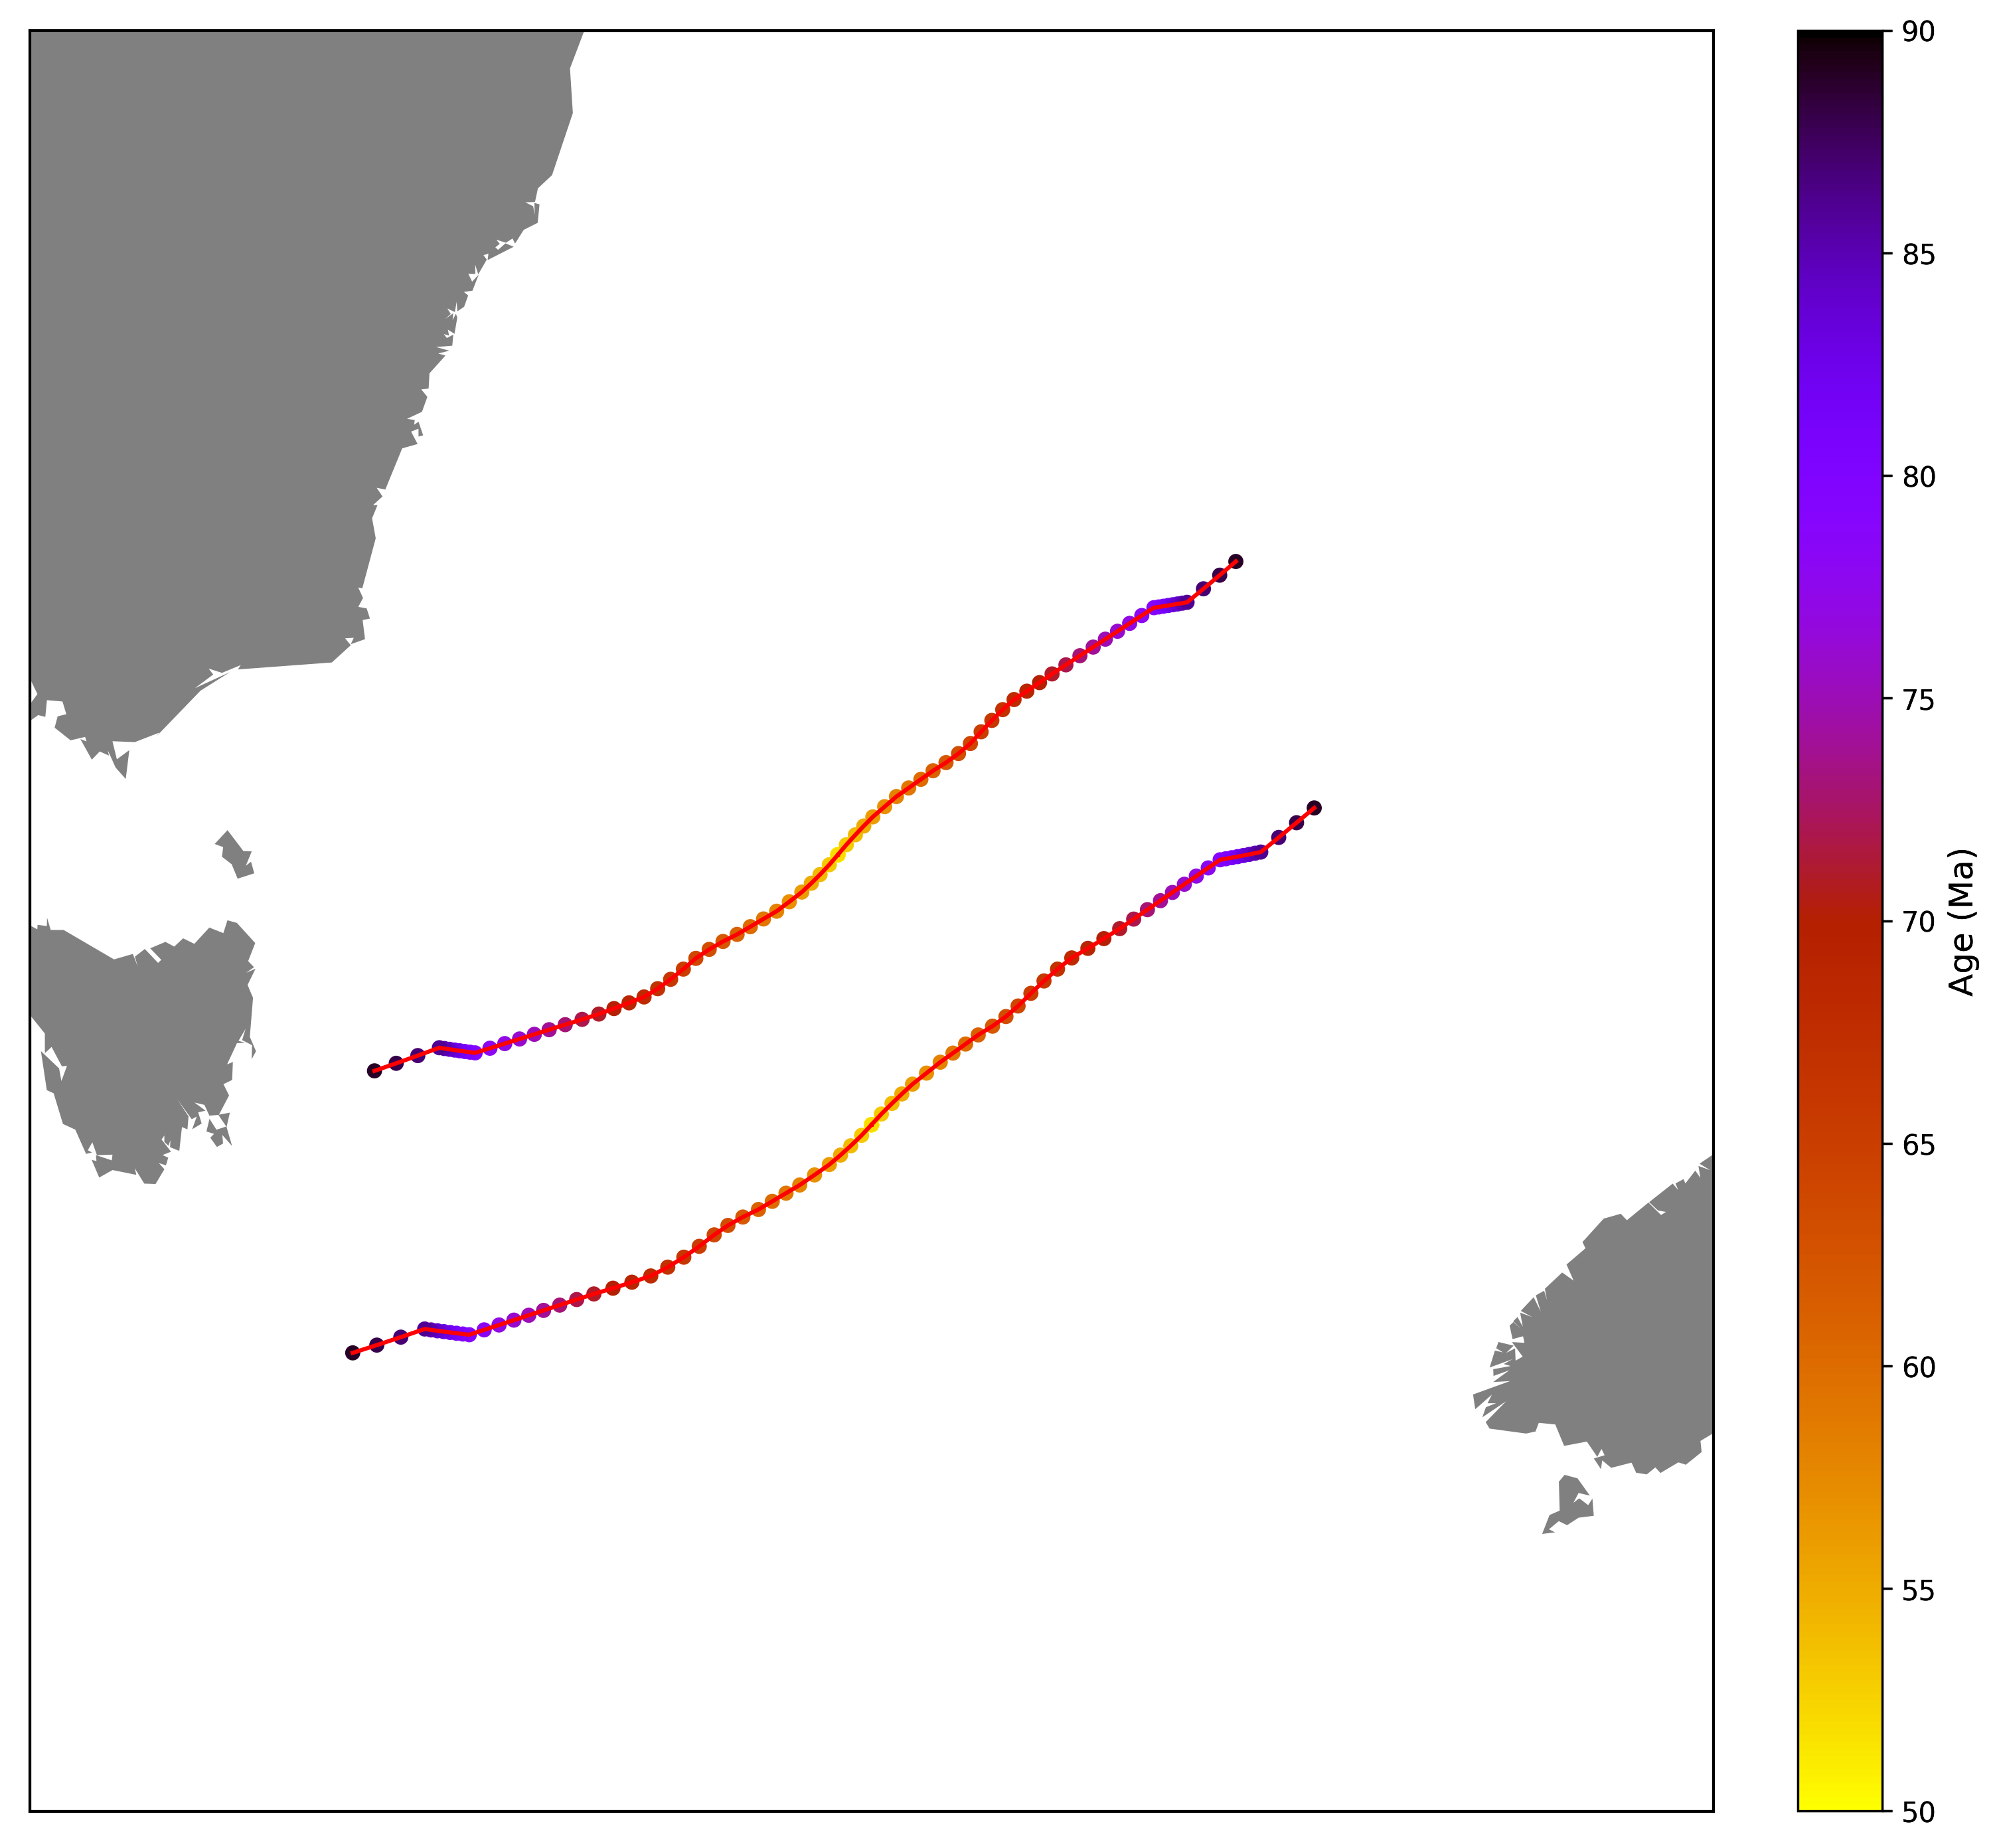

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Plot basemap
fig = plt.figure(figsize=(12,12),dpi=300)
pmap = Basemap(llcrnrlon=145,llcrnrlat=-50,urcrnrlon=170,urcrnrlat=-30,\
            rsphere=(6378137.00),\
            resolution='l',projection='merc',\
            lat_0=-40.,lon_0=156.,lat_ts=-40.)
clip_path = pmap.drawmapboundary()
pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', zorder=2)
ax = plt.gca()
pmap.etopo(alpha=0.6)

for reconstructed_flowline in reconstructed_flowlines:
    # Iterate over the left flowline points
    flowlinearray_left = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    # Iterate over the right flowline points
    flowlinearray_right = np.empty([0,0])
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

    x,y = pmap(flowlinearray_left[1::2],flowlinearray_left[::2])
    l1,=pmap.plot(x, y, 'r', clip_path=clip_path,zorder=2)
    l3=pmap.scatter(x, y, 30, c=times,
                          cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=50,vmax=90)
    
    x,y = pmap(flowlinearray_right[1::2],flowlinearray_right[::2])
    pmap.plot(x, y, 'r', clip_path=clip_path,zorder=2)
    l3=pmap.scatter(x, y, 30, c=times,
                          cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=50,vmax=90)
    
    cbar = pmap.colorbar(l3,location='right',pad="5%")
    cbar.set_label('Age (Ma)',fontsize=12)


plt.show()
